# Python version - Supermodel - Nutrient Pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Included N_pulse as a param

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']


    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - q_H * E_H * H - m_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -((v_m * N * PH) / (k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                m_P * P)

    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [32]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.03) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [33]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

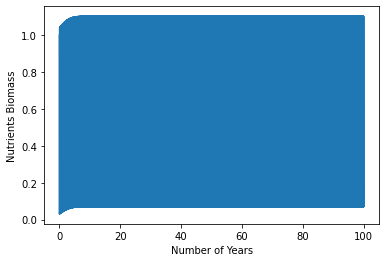

In [34]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

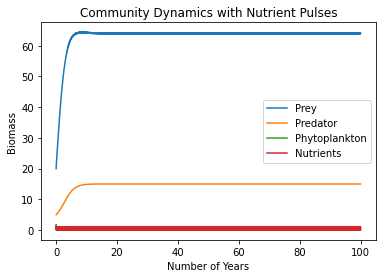

In [35]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

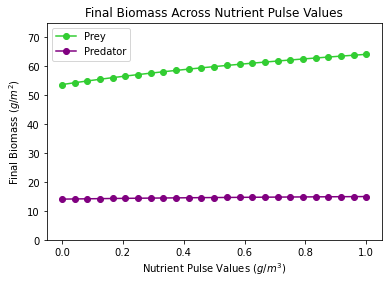

In [36]:
# Define the range of N_pulse_array values to plot
size = 25
N_pulse_array = np.linspace(0.0, 1.0, size)
N_final_array = np.zeros(size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, N_pulse in enumerate(N_pulse_array):
    parameters_dict['N_pulse'] = N_pulse
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    N_final_array[i] = np.mean(N_array[-3650:-1])
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])

# Plot the final abundances
#plt.plot(N_pulse_array, N_final_array, label='Nutrients', color="red", marker="o")
plt.plot(N_pulse_array, H_final_array, label='Prey', color="limegreen", marker="o")
plt.plot(N_pulse_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Biomass Across Nutrient Pulse Values')
plt.xlabel('Nutrient Pulse Values $(g/m^3)$')
plt.ylabel('Final Biomass $(g/m^2)$')
plt.ylim(0,75)
plt.legend()

plt.savefig("figs/N_pulse_biomasses.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

# Show the plot
plt.show()

In [19]:
print(P_final_array)

[14.09816629 14.15740118 14.21325115 14.26606491 14.31613927 14.36372908
 14.40905489 14.45230891 14.49365974 14.5332561  14.57122989 14.60769867
 14.64276764 14.67653138 14.70907522 14.74047642 14.77080515 14.80012537
 14.82849551 14.85596913 14.8825954  14.90841961 14.93348357 14.95782592
 14.98148249]


## Fishing Heatmaps

In [9]:
def default_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 100 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.8/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.2/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.4/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.8/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.25/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = (0.03) # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

# Fishing Heatmaps - Constant N Pulse

In [134]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.03) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [10]:
#parameters_dict = default_params()

#N_pulse = 0.1
size = 5
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

for i in np.arange(0, size):
        for j in np.arange(0, size):
            E_H = E_H_array[i]
            E_P = E_P_array[j] 
            parameters_dict['E_H'] = E_H/365 
            parameters_dict['E_P'] = E_P/365 
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_last = np.mean(H_array[-3650:-1])
            P_last = np.mean(P_array[-3650:-1])
            T_last = np.add(H_last, P_last)
            heatmap_T[i,j] = T_last
            heatmap_H[i,j] = H_last
            heatmap_P[i,j] = P_last
            j+=1
        i+=1

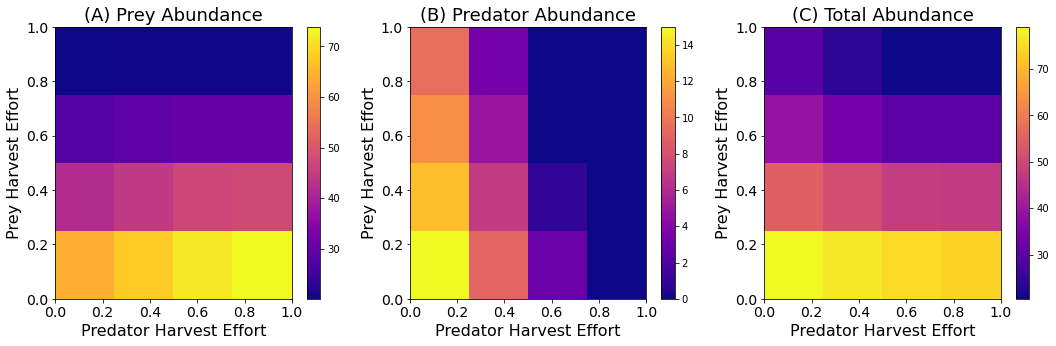

In [130]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)

In [131]:
print(heatmap_H)

[[64.04467775 67.85658049 71.80279798 73.84995637 73.84996758]
 [41.89607551 44.33041738 47.00273235 47.45726074 47.45726075]
 [28.12784364 29.20781917 30.20066734 30.20284188 30.20284188]
 [20.07850651 20.32184246 20.46820236 20.46820386 20.46820386]
 [15.22672161 15.05607154 14.99178696 14.99178695 14.99178695]]


In [133]:
size = 5
N_pulse_values = [0.1, 0.4, 1.0]
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

for i in range(3): 
    parameters_dict['N_pulse'] = N_pulse_values 
    
    for j in np.arange(0, size):
        for k in np.arange(0, size):
            E_H = E_H_array[j]
            E_P = E_P_array[k] 
            parameters_dict['E_H'] = E_H/365 
            parameters_dict['E_P'] = E_P/365 
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_last = np.mean(H_array[-3650:-1])
            P_last = np.mean(P_array[-3650:-1])
            T_last = np.add(H_last, P_last)
            heatmap_T[j,k] = T_last
            heatmap_H[j,k] = H_last
            heatmap_P[j,k] = P_last
            k+=1
        j+=1
            
            

ValueError: setting an array element with a sequence.

### Add in a 3rd dimension, (add idx to the heatmap) [i,j,idx]

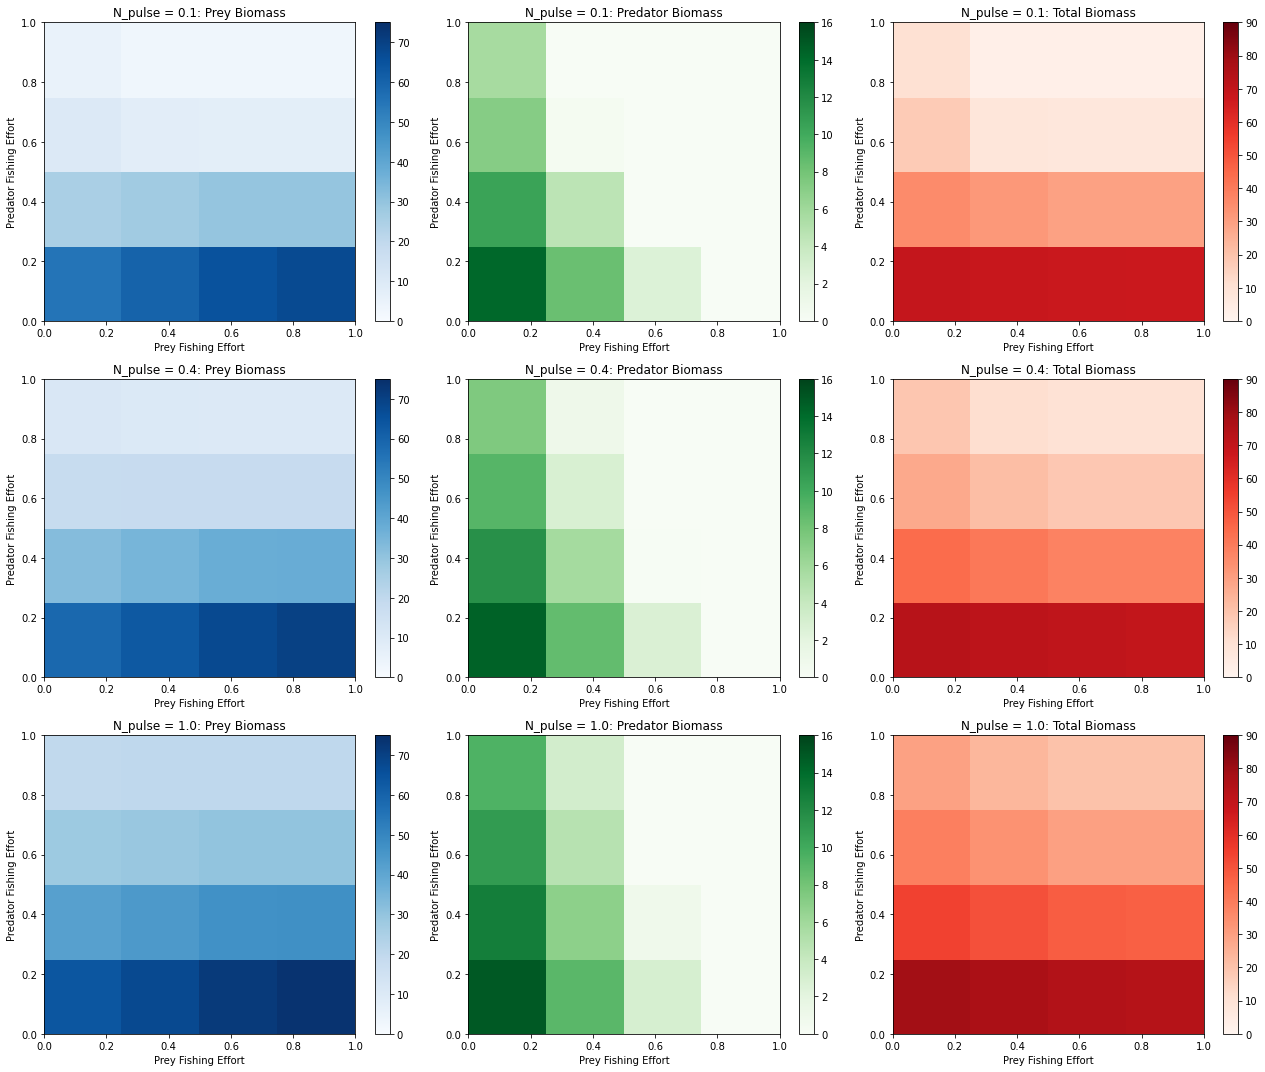

In [145]:
# Define parameters
N_pulse_values = [0.1, 0.4, 1.0]
size = 5
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=len(N_pulse_values), ncols=3, figsize=(18, 5 * len(N_pulse_values)))

for idx, N_pulse in enumerate(N_pulse_values):
    for i in np.arange(0, size):
        for j in np.arange(0, size):
            E_H = E_H_array[i]
            E_P = E_P_array[j] 
            parameters_dict['E_H'] = E_H / 365
            parameters_dict['E_P'] = E_P / 365
            parameters_dict['N_pulse'] = N_pulse
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_last = np.mean(H_array[-3650:-1])
            P_last = np.mean(P_array[-3650:-1])
            T_last = H_last + P_last
            heatmap_T[i, j] = T_last
            heatmap_H[i, j] = H_last
            heatmap_P[i, j] = P_last
    
    # Plot the heatmap for this N_pulse value
    ax0, ax1, ax2 = axes[idx]
    
    im = ax0.pcolormesh(E_H_array, E_P_array, heatmap_H, cmap=plt.cm.get_cmap('Blues'), shading='auto', vmin = 0, vmax = 75)
    fig.colorbar(im, ax=ax0, orientation="vertical", pad=0.05)
    ax0.set_title(f"N_pulse = {N_pulse}: Prey Biomass")
    ax0.set_ylabel("Predator Fishing Effort")
    ax0.set_xlabel("Prey Fishing Effort")

    im = ax1.pcolormesh(E_H_array, E_P_array, heatmap_P, cmap=plt.cm.get_cmap('Greens'), shading='auto', vmin=0, vmax = 16)
    fig.colorbar(im, ax=ax1, orientation="vertical", pad=0.05)
    ax1.set_title(f"N_pulse = {N_pulse}: Predator Biomass")
    ax1.set_ylabel("Predator Fishing Effort")
    ax1.set_xlabel("Prey Fishing Effort")

    im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('Reds'), shading='auto', vmin=0, vmax = 90)
    fig.colorbar(im, ax=ax2, orientation="vertical", pad=0.05)
    ax2.set_title(f"N_pulse = {N_pulse}: Total Biomass")
    ax2.set_ylabel("Predator Fishing Effort")
    ax2.set_xlabel("Prey Fishing Effort")

plt.tight_layout()
plt.show()

In [142]:
np.max(heatmap_H)

73.84996758352898

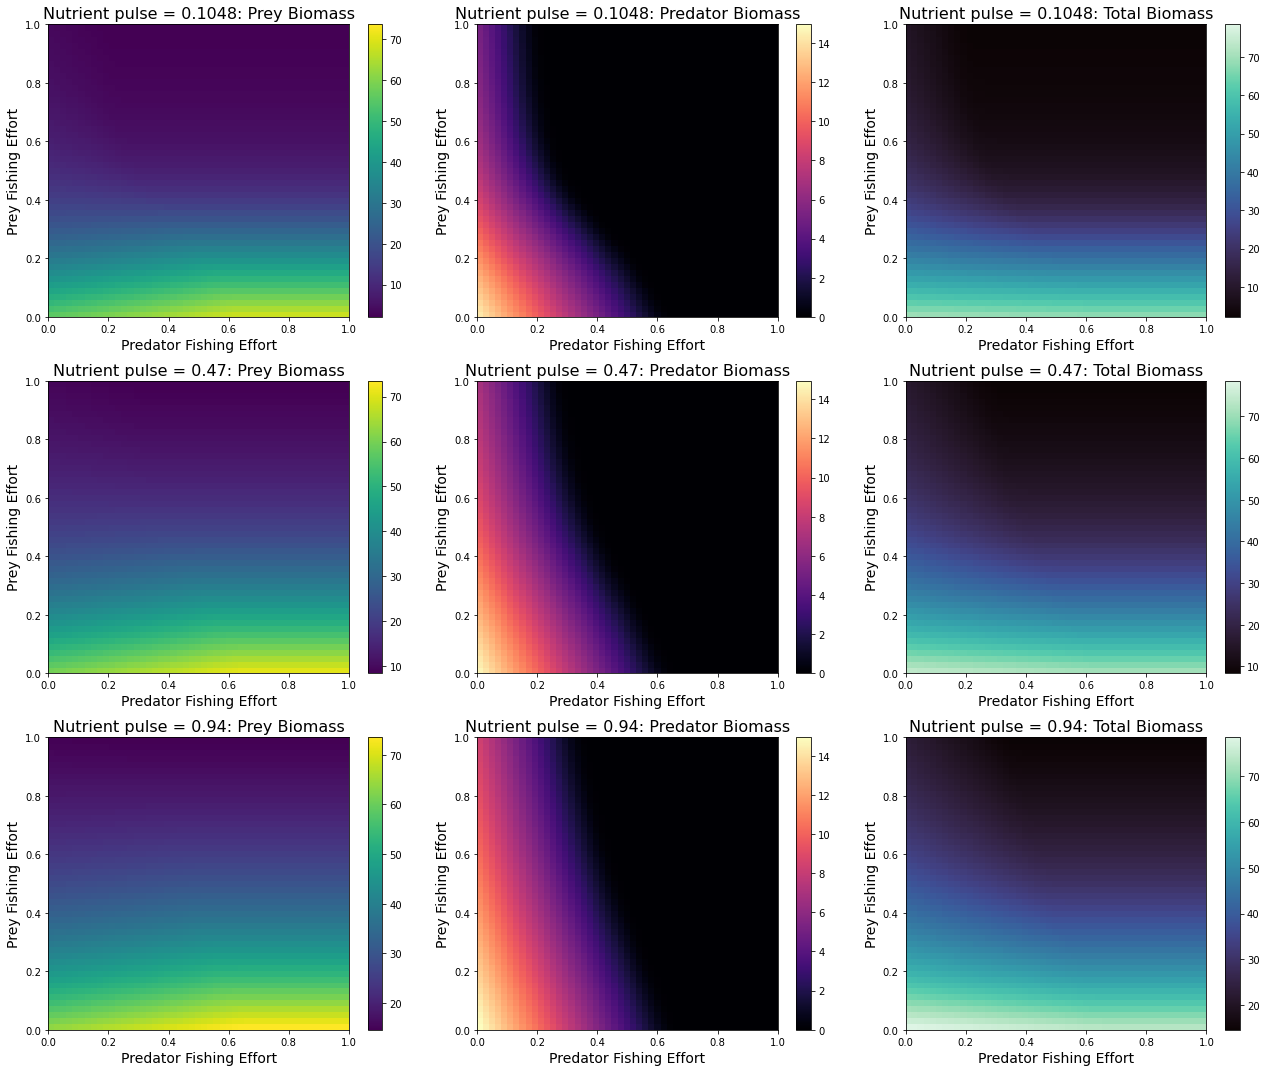

In [38]:
# Define parameters
N_pulse_values = [0.1048, 0.47, 0.94]
size = 50
heatmap_H = np.zeros((len(N_pulse_values), size, size))
heatmap_P = np.zeros((len(N_pulse_values), size, size))
heatmap_T = np.zeros((len(N_pulse_values), size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        for j in range(size):
            E_H = E_H_array[i]
            E_P = E_P_array[j]
            parameters_dict['E_H'] = E_H / 365
            parameters_dict['E_P'] = E_P / 365
            parameters_dict['N_pulse'] = N_pulse
            
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_last = np.mean(H_array[-3650:])
            P_last = np.mean(P_array[-3650:])
            T_last = H_last + P_last
            heatmap_H[idx, i, j] = H_last
            heatmap_P[idx, i, j] = P_last
            heatmap_T[idx, i, j] = T_last

            

max_H = np.max(heatmap_H)
max_P = np.max(heatmap_P)
max_T = np.max(heatmap_T)

# Plot the results outside the loop
fig, axes = plt.subplots(nrows=len(N_pulse_values), ncols=3, figsize=(18, 5 * len(N_pulse_values)))

for idx, N_pulse in enumerate(N_pulse_values):
    ax0, ax1, ax2 = axes[idx]
    
    im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H[idx], cmap=plt.cm.get_cmap('viridis'), shading='auto', vmax = max_H)
    fig.colorbar(im, ax=ax0, orientation="vertical", pad=0.05)
    ax0.set_title(f"Nutrient pulse = {N_pulse}: Prey Biomass", fontsize = 16)
    ax0.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax0.set_xlabel("Predator Fishing Effort", fontsize = 14)

    im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P[idx], cmap=plt.cm.get_cmap('magma'), shading='auto', vmax = max_P)
    fig.colorbar(im, ax=ax1, orientation="vertical", pad=0.05)
    ax1.set_title(f"Nutrient pulse = {N_pulse}: Predator Biomass", fontsize = 16)
    ax1.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax1.set_xlabel("Predator Fishing Effort", fontsize = 14)

    im = ax2.pcolormesh(E_P_array, E_H_array, heatmap_T[idx], cmap=plt.cm.get_cmap('mako'), shading='auto', vmax = max_T)
    fig.colorbar(im, ax=ax2, orientation="vertical", pad=0.05)
    ax2.set_title(f"Nutrient pulse = {N_pulse}: Total Biomass", fontsize = 16)
    ax2.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax2.set_xlabel("Predator Fishing Effort", fontsize = 14)

plt.tight_layout()

plt.savefig("figs/N_pulse_heatmap_biomasses.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

In [29]:
print(heatmap_H)

[[[55.09418727 60.14201327 65.33119238 67.63695755 67.63696066]
  [25.31557244 27.49152084 29.77636951 29.78119675 29.78119675]
  [10.46965529  7.94482647  7.68652911  7.68652907  7.68652907]
  [ 5.37734857  3.19621654  3.19074936  3.19074936  3.19074936]
  [ 3.43468444  1.951001    1.95020242  1.95020242  1.95020242]]

 [[58.76939359 63.26687971 67.91323118 70.12298127 70.1229866 ]
  [32.79374438 35.27272635 38.04677762 38.15055272 38.15055272]
  [18.395108   18.56713055 18.66934521 18.66934563 18.66934563]
  [11.5410695  10.7004256  10.53664949 10.53664949 10.53664949]
  [ 8.08985413  7.09003028  7.04373951  7.04373951  7.04373951]]

 [[64.04467243 67.85657575 71.80279384 73.84995255 73.84996375]
  [41.89607135 44.33041359 47.00272937 47.4572574  47.4572574 ]
  [28.12784327 29.20781941 30.20066822 30.20284262 30.20284262]
  [20.07850944 20.32184619 20.46820652 20.46820803 20.46820803]
  [15.22672669 15.05607741 14.99179309 14.99179307 14.99179307]]]


In [30]:
print(heatmap_P)

[[[1.42347233e+01 8.42081035e+00 2.57929263e+00 2.32694895e-06
   2.53922419e-16]
  [1.04725288e+01 4.59535845e+00 6.59175457e-03 1.18868416e-12
   1.36654844e-22]
  [7.21277626e+00 4.25152018e-01 5.14703307e-10 6.35238304e-20
   7.96657630e-30]
  [5.69207248e+00 9.79846365e-03 2.20746236e-12 2.67665158e-22
   3.39498193e-32]
  [5.03556152e+00 2.09765910e-03 3.79669884e-13 4.56688241e-23
   5.79634518e-33]]

 [[1.45562273e+01 8.67128575e+00 2.76917344e+00 4.84905485e-06
   5.43480646e-16]
  [1.16717709e+01 5.77290176e+00 1.87011165e-01 9.27713921e-11
   1.04495133e-20]
  [9.12904521e+00 2.91574993e+00 7.45617957e-06 9.67342765e-16
   1.15634151e-25]
  [7.50066426e+00 1.04605685e+00 7.05536799e-09 8.50280219e-19
   1.04500443e-28]
  [6.53526804e+00 2.51540552e-01 1.78174667e-10 2.11960304e-20
   2.63327307e-30]]

 [[1.49814825e+01 9.01509139e+00 3.03999118e+00 1.32070892e-05
   1.54385522e-15]
  [1.28680826e+01 6.89891251e+00 9.57943760e-01 5.11529512e-09
   5.75233549e-19]
  [1.0950374

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-pa

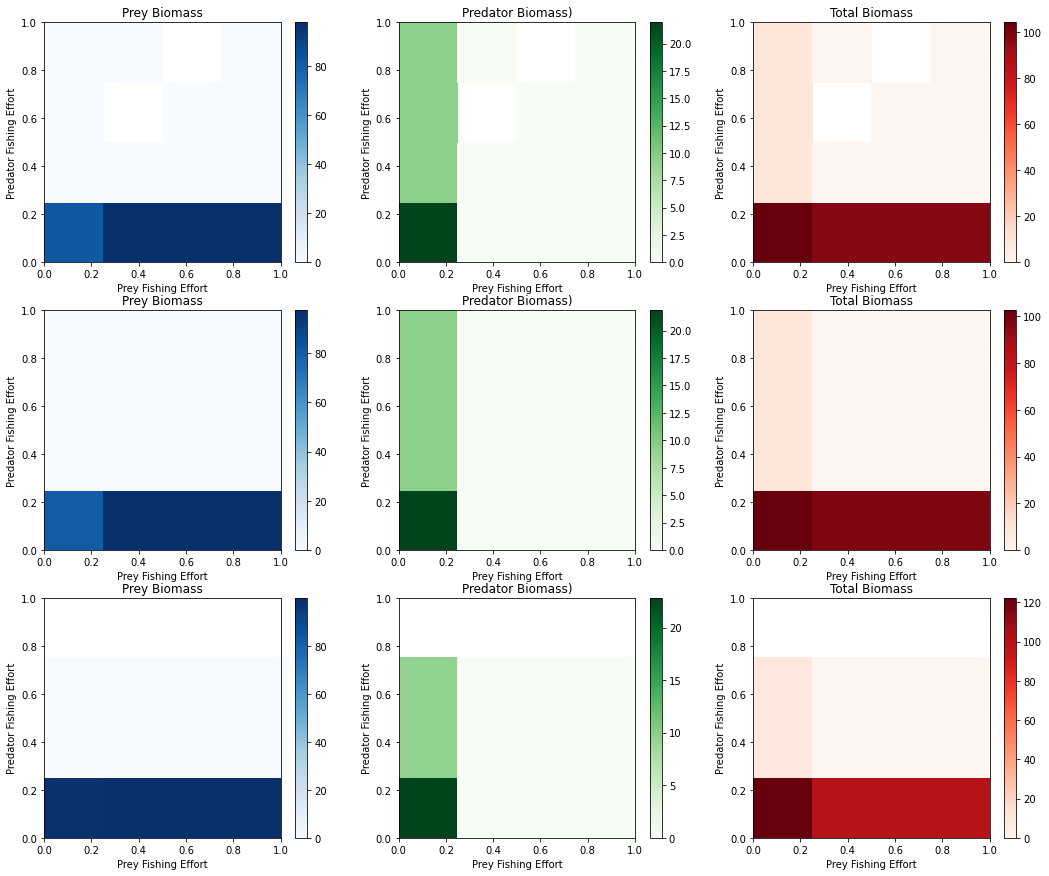

In [25]:
parameters_dict = default_params()

size = 5
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)
N_pulse_values = [0.1048, 10, 100]

 # Create a grid of subplots for each N_pulse_value
fig, axes = plt.subplots(nrows=len(N_pulse_values), ncols=3, figsize=(18, 5 * len(N_pulse_values)))

for idx, N_pulse in enumerate(N_pulse_values):
    N_pulse = N_pulse_values[idx]
    parameters_dict['N_pulse'] = N_pulse
    #heatmap_H = np.zeros((size, size))
    #heatmap_P = np.zeros((size, size))
    #heatmap_T = np.zeros((size, size))
    
    #Loop through E_P and E_H values from 0-1 
    for i in np.arange(0, size):
        for j in np.arange(0, size):
            E_H = E_H_array[i]
            E_P = E_P_array[j] 
            parameters_dict['E_H'] = E_H 
            parameters_dict['E_P'] = E_P 
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_last = np.mean(H_array[-10:-1])
            P_last = np.mean(P_array[-10:-1])
            T_last = np.mean(np.add(H_array[-10:-1], P_array[-10:-1]))
            heatmap_T[i,j] = T_last
            heatmap_H[i,j] = H_last
            heatmap_P[i,j] = P_last
            j+=1
        i+=1
        
        # Create subplots for each heatmap
    ax0, ax1, ax2 = axes[idx]
    
    im = ax0.pcolormesh(E_H_array, E_P_array, heatmap_H, cmap=plt.cm.get_cmap('Blues'), shading='auto')
    fig.colorbar(im, ax=ax0, orientation="vertical", pad=0.05)
    ax0.set_title(f"Prey Biomass")
    ax0.set_ylabel("Predator Fishing Effort")
    ax0.set_xlabel("Prey Fishing Effort")

    im = ax1.pcolormesh(E_H_array, E_P_array, heatmap_P, cmap=plt.cm.get_cmap('Greens'), shading='auto')
    fig.colorbar(im, ax=ax1, orientation="vertical", pad=0.05)
    ax1.set_title(f"Predator Biomass)")
    ax1.set_ylabel("Predator Fishing Effort")
    ax1.set_xlabel("Prey Fishing Effort")

    im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('Reds'), shading='auto')
    fig.colorbar(im, ax=ax2, orientation="vertical", pad=0.05)
    ax2.set_title(f"Total Biomass")
    ax2.set_ylabel("Predator Fishing Effort")
    ax2.set_xlabel("Prey Fishing Effort")
   
    

# N_pulse current day

In [35]:
parameters_dict = default_params()

N_pulse = 0.1
size = 10
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

for i in np.arange(0, size):
    for j in np.arange(0, size):
        E_H = E_H_array[i]
        E_P = E_P_array[j] 
        parameters_dict['E_H'] = E_H 
        parameters_dict['E_P'] = E_P 
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_last = np.mean(H_array[-10:-1])
        P_last = np.mean(P_array[-10:-1])
        T_last = np.mean(np.add(H_array[-10:-1], P_array[-10:-1]))
        heatmap_T[i,j] = T_last
        heatmap_H[i,j] = H_last
        heatmap_P[i,j] = P_last
        j+=1
    i+=1
    
    

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


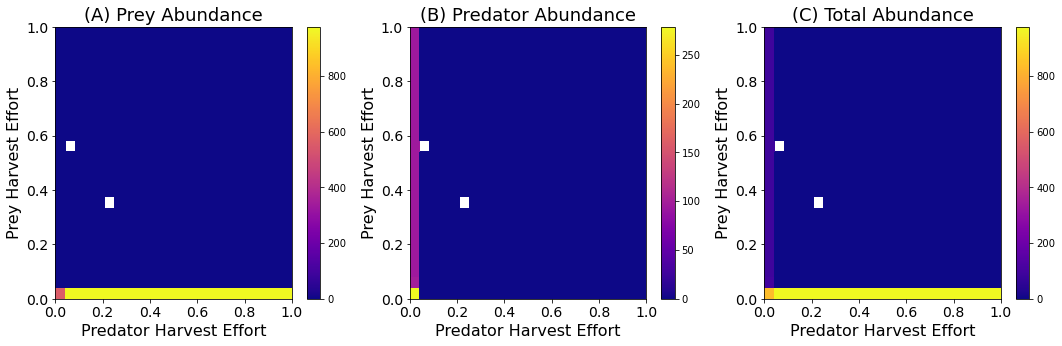

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)

# N_pulse 50% restored

In [37]:
parameters_dict = default_params()

N_pulse = 0.4
size = 10
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

for i in np.arange(0, size):
    for j in np.arange(0, size):
        E_H = E_H_array[i]
        E_P = E_P_array[j] 
        parameters_dict['E_H'] = E_H 
        parameters_dict['E_P'] = E_P 
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_last = np.mean(H_array[-10:-1])
        P_last = np.mean(P_array[-10:-1])
        T_last = np.mean(np.add(H_array[-10:-1], P_array[-10:-1]))
        heatmap_T[i,j] = T_last
        heatmap_H[i,j] = H_last
        heatmap_P[i,j] = P_last
        j+=1
    i+=1

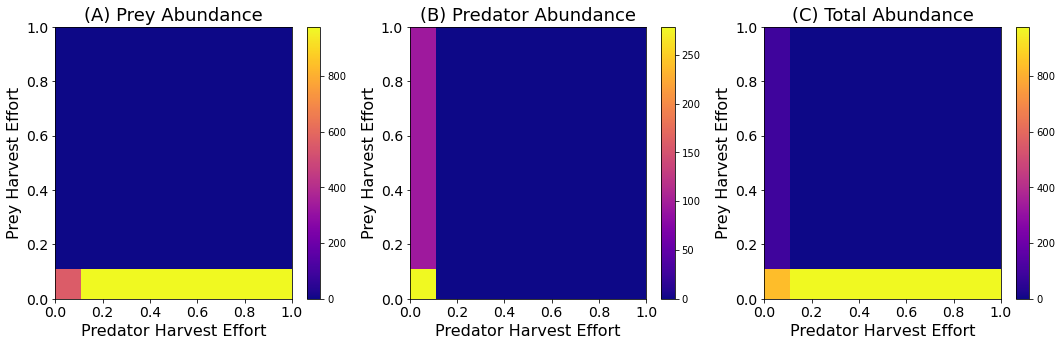

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)

## N_pulse 100% restored

In [50]:
parameters_dict = default_params()

N_pulse = 0.9
size = 10
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 0.5, size)
E_P_array = np.linspace(0, 0.5, size)

for i in np.arange(0, size):
    for j in np.arange(0, size):
        E_H = E_H_array[i]
        E_P = E_P_array[j] 
        parameters_dict['E_H'] = E_H 
        parameters_dict['E_P'] = E_P 
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_last = np.mean(H_array[-10:-1])
        P_last = np.mean(P_array[-10:-1])
        T_last = np.mean(np.add(H_array[-10:-1], P_array[-10:-1]))
        heatmap_T[i,j] = T_last
        heatmap_H[i,j] = H_last
        heatmap_P[i,j] = P_last
        j+=1
    i+=1

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


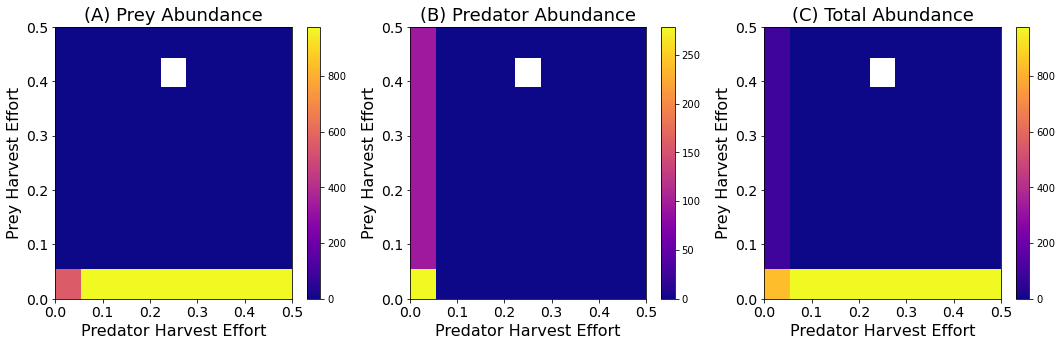

In [51]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)

Text(0.5, 0, 'Additional Prey Mortality ($c$)')

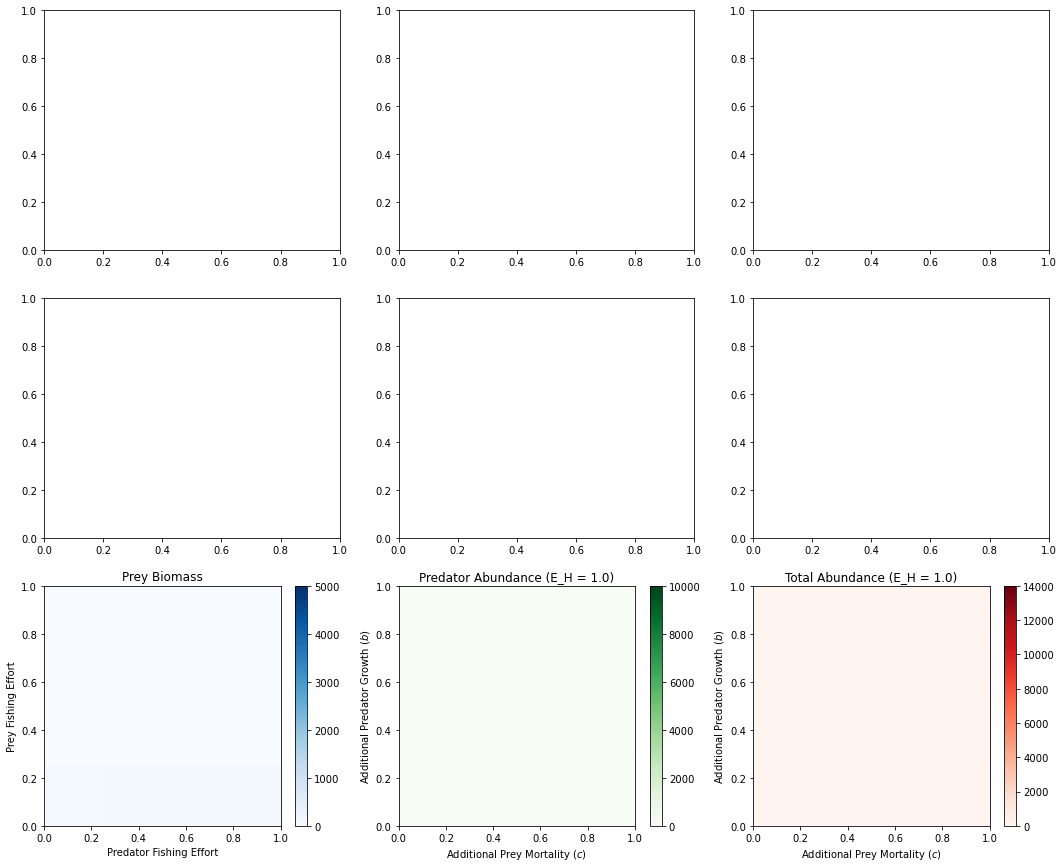

In [21]:
 # Create a 2x3 grid of subplots for each E_H value
fig, axes = plt.subplots(nrows=len(N_pulse_values), ncols=3, figsize=(18, 5 * len(N_pulse_values)))
    # Create subplots for each heatmap
ax0, ax1, ax2 = axes[idx]
    
im = ax0.pcolormesh(E_H_array, E_P_array, heatmap_H, cmap=plt.cm.get_cmap('Blues'), shading='auto', vmin=0, vmax=5000)
fig.colorbar(im, ax=ax0, orientation="vertical", pad=0.05)
ax0.set_title(f"Prey Biomass")
ax0.set_ylabel("Prey Fishing Effort")
ax0.set_xlabel("Predator Fishing Effort")

im = ax1.pcolormesh(E_H_array, E_P_array, heatmap_P, cmap=plt.cm.get_cmap('Greens'), shading='auto', vmin=0, vmax=10000)
fig.colorbar(im, ax=ax1, orientation="vertical", pad=0.05)
ax1.set_title(f"Predator Abundance (E_H = {E_H})")
ax1.set_ylabel("Additional Predator Growth ($b$)")
ax1.set_xlabel("Additional Prey Mortality ($c$)")

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('Reds'), shading='auto', vmin=0, vmax=14000)
fig.colorbar(im, ax=ax2, orientation="vertical", pad=0.05)
ax2.set_title(f"Total Abundance (E_H = {E_H})")
ax2.set_ylabel("Additional Predator Growth ($b$)")
ax2.set_xlabel("Additional Prey Mortality ($c$)")

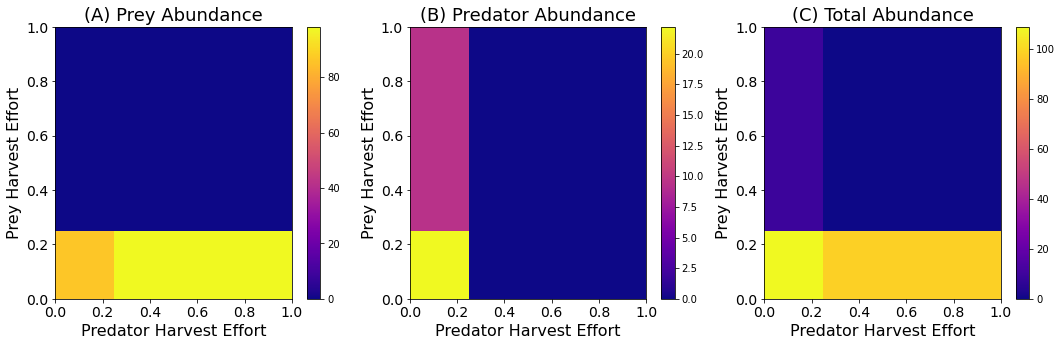

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)